In [1]:
import pandas as pd

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

train_data.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
import numpy as np
import seaborn as sns

In [3]:
train_data['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [4]:

train_data['keyword'].fillna('unknown', inplace=True)
train_data['location'].fillna('unknown', inplace=True)
print(train_data.isnull().sum())


id          0
keyword     0
location    0
text        0
target      0
dtype: int64


/var/folders/rk/2j2lpdqx5dx3vlnwy2lx96lw0000gn/T/ipykernel_35606/4197938230.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['keyword'].fillna('unknown', inplace=True)
/var/folders/rk/2j2lpdqx5dx3vlnwy2lx96lw0000gn/T/ipykernel_35606/4197938230.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

EDA

In [5]:
print(train_data['target'].value_counts())

target
0    4342
1    3271
Name: count, dtype: int64


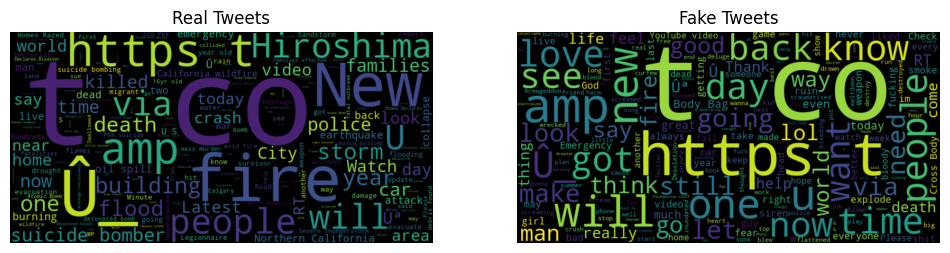

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

real_tweets = train_data[train_data['target'] == 1]['text']
fake_tweets = train_data[train_data['target'] == 0]['text']

wc_real = WordCloud(width=800, height=400).generate(' '.join(real_tweets))
wc_fake = WordCloud(width=800, height=400).generate(' '.join(fake_tweets))

plt.figure(figsize=(12, 6))

# Real tweets
plt.subplot(1, 2, 1)
plt.imshow(wc_real, interpolation='bilinear')
plt.title("Real Tweets")
plt.axis("off")

# Fake tweets
plt.subplot(1, 2, 2)
plt.imshow(wc_fake, interpolation='bilinear')
plt.title("Fake Tweets")
plt.axis("off")

plt.show()


Preprocessing

In [7]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # URLs
    text = re.sub(r'\d+', '', text)  # numbers
    text = re.sub(r'[^\w\s]', '', text)  # punctuation
    tokens = text.lower().split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

train_data['clean_text'] = train_data['text'].apply(preprocess_text)


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


In [8]:
import ssl
import nltk
import certifi

ssl._create_default_https_context = ssl.create_default_context
nltk.download('stopwords')


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


False

In [9]:
import nltk
nltk.download('stopwords', download_dir='/Users/lykofos/Desktop/clubs/GDG/MSA/assignment-1')


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


False

Since there was some certificate error, I dowloaded the stopwords package from the OG github.

In [10]:
from nltk.corpus import stopwords

nltk.data.path.append('/Users/lykofos/Desktop/clubs/GDG/MSA/assignment-1/stopwords.zip')
stop_words = set(stopwords.words('english'))


In [11]:
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # URLs
    text = re.sub(r'\d+', '', text)  # numbers
    text = re.sub(r'[^\w\s]', '', text)  # punctuation
    tokens = text.lower().split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

train_data['clean_text'] = train_data['text'].apply(preprocess_text)

Feature Extraction and vectorization

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data['clean_text'])


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_data['clean_text'])


Model Training

In [14]:
from sklearn.model_selection import train_test_split

X = X_train
y = train_data['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

def model_Evaluate(model):
    
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    cf_matrix = confusion_matrix(y_val, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.82      0.68      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



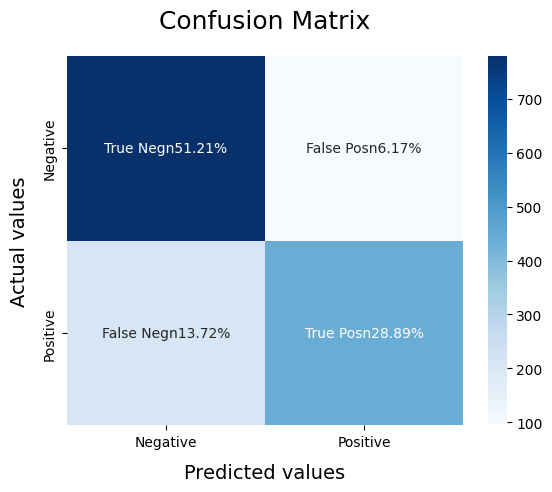

In [16]:
from sklearn.linear_model import LogisticRegression


LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_val)


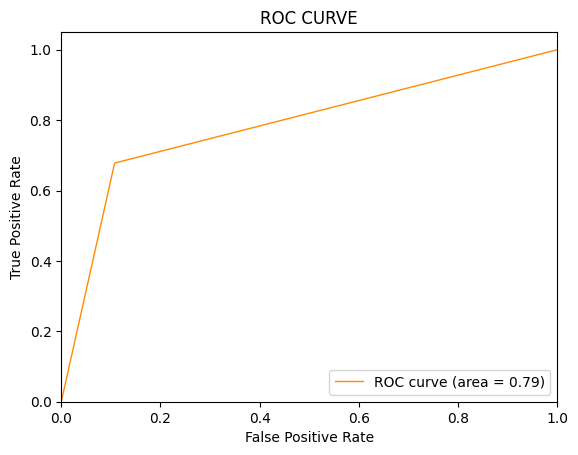

In [17]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.79      0.89      0.83       874
           1       0.82      0.68      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



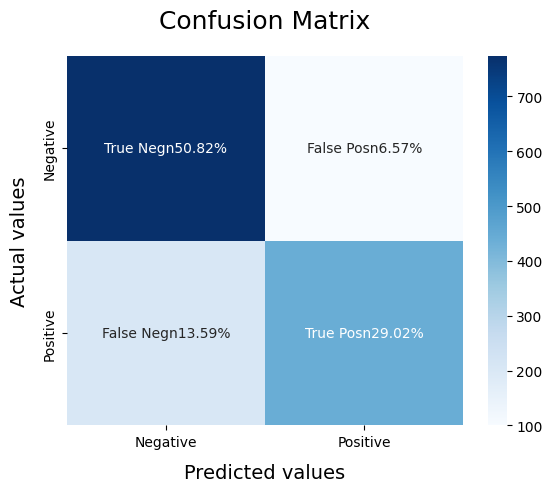

In [18]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_val)



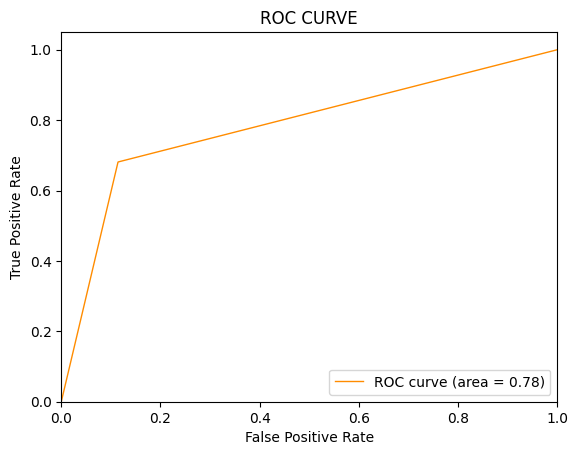

In [19]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       874
           1       0.76      0.71      0.73       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



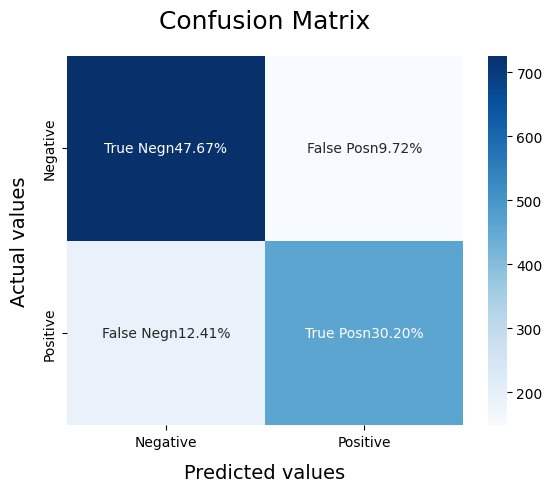

In [20]:
from sklearn.svm import LinearSVC
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_val)



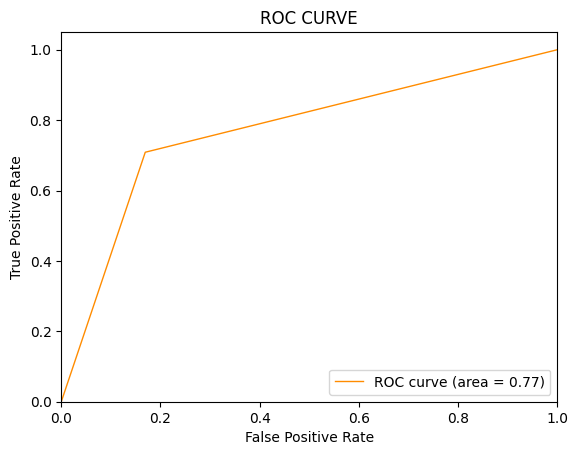

In [21]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

Hyperparameter tuning

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'C': 1}


Deployment

In [25]:
!pip install gradio


DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/selenium-3.141.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached fastapi-0.115.6-py3-none-any.whl.metadata (27 kB)
  Using cached huggingface_hub-0.27.0-py3-none-any.whl.metadata (13 kB)
  Using cached pydantic-2.10.4-py3-none-any.whl.metadata (29 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached uvicorn-0.34.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached starlette-0.41.3-py3-none-any.whl.metadata (6.0 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.27.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.6 k

In [27]:
!pip install pickle


DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/selenium-3.141.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [29]:
import pickle

# Save Logistic Regression model
with open("LRmodel.pkl", "wb") as model_file:
    pickle.dump(LRmodel, model_file)

# Save TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(tfidf, vectorizer_file)


In [30]:
import pickle
import gradio as gr


with open("LRmodel.pkl", "rb") as model_file:
    LRmodel = pickle.load(model_file)


with open("tfidf_vectorizer.pkl", "rb") as vectorizer_file:
    tfidf = pickle.load(vectorizer_file)

def classify_tweet(tweet):
    """Classify a tweet as Real or Fake using the trained model."""
    processed_tweet = tfidf.transform([tweet])
    prediction = LRmodel.predict(processed_tweet)[0]
    return "Real" if prediction == 1 else "Fake"

# Gradio Interface
interface = gr.Interface(
    fn=classify_tweet,
    inputs=gr.Textbox(lines=3, placeholder="Enter a tweet here..."),
    outputs="text",
    title="Fake News Detection App",
    description="Enter a tweet to classify it as Real or Fake."
)

# Launch the app
interface.launch()


Running on local URL:  http://127.0.0.1:7861


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gradio/analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.41.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(



To create a public link, set `share=True` in `launch()`.
